# Wellness 심리 상담 데이터에 대한 KoELECTRA 학습 Question & Answer 
데이터와 클래스 셋으로 이루어져, 질의 데이터가 들어왔을 때, Answer 클래스를 예측하도록 학습

## 1.Google Drive 연동
- 모델 파일과 학습 데이터가 저장 되어있는 구글 드라이브의 디렉토리와 Colab을 연동.  
- 좌측상단 메뉴에서 런타임-> 런타임 유형 변경 -> 하드웨어 가속기 -> GPU 선택 후 저장

### 1.1 GPU 연동 확인

In [12]:
!nvidia-smi

Mon Jul 27 00:37:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    34W / 250W |   1275MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2 Google Drive 연동
아래 코드를 실행후 나오는 URL을 클릭하여 나오는 인증 코드 입력

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Colab 디렉토리 아래 dialogLM 경로 확인**




In [14]:
!ls drive/'My Drive'/'Colab Notebooks'/

 BERT_X		      'fastprogress example.ipynb'    NarrativeKoGPT2
 Data		       KorQuAD-beginner		      ReforBERT
 dialogLM	       korquad-finetuing.ipynb
 EnlipleBERTFintuing   korquad-finetuing-ver2.ipynb


**필요 패키지 설치**

In [15]:
!pip install -r drive/'My Drive'/'Colab Notebooks'/dialogLM/requirements.txt

## KoBERT QA Training

**Path 추가**

In [16]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/')
sys.path.append('drive/My Drive/Colab Notebooks/dialogLM')

### 2.1 import package

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import (
  AdamW,
  ElectraConfig,
  ElectraTokenizer
)
from torch.utils.data import dataloader
from dialogLM.dataloader.wellness import WellnessTextClassificationDataset
from dialogLM.model.koelectra import koElectraForSequenceClassification

In [18]:
torch.cuda.is_available()

True

**Train 함수**

In [19]:
def train(epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):
            optimizer.zero_grad()

            '''
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'bias_labels': batch[3],
                      'hate_labels': batch[4]}
            if self.args.model_type != 'distilkobert':
              inputs['token_type_ids'] = batch[2]
            '''
            inputs = {'input_ids': data['input_ids'],
                      'attention_mask': data['attention_mask'],
                      'labels': data['labels']
                      }
            outputs = model(**inputs)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'loss': loss.item(),  # Loss 저장
                    'train_step': i,  # 현재 진행한 학습
                    'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
                }, save_ckpt_path)

    return np.mean(losses)

### KoBERT Question & Answer Training for Wellness dataset

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing koElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing koElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing koElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of koElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized

,loss
0,5.739058
1,5.506657
2,5.370526
3,5.185486
4,4.976643
5,4.752509
6,4.533144
7,4.312760
8,4.093869
9,3.885595


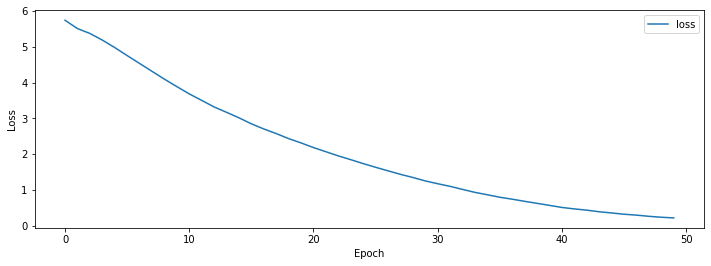

In [20]:
root_path='drive/My Drive/Colab Notebooks/dialogLM'
data_path = f"{root_path}/data/wellness_dialog_for_text_classification_train.txt"
checkpoint_path =f"{root_path}/checkpoint"
save_ckpt_path = f"{checkpoint_path}/koelectra-wellnesee-text-classification.pth"
model_name_or_path = "monologg/koelectra-base-discriminator"


n_epoch = 50          # Num of Epoch
batch_size = 16      # 배치 사이즈
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
save_step = 100 # 학습 저장 주기
learning_rate = 5e-6  # Learning Rate

# Electra Tokenizer
tokenizer = ElectraTokenizer.from_pretrained(model_name_or_path)

# WellnessTextClassificationDataset 데이터 로더
dataset = WellnessTextClassificationDataset(file_path=data_path, tokenizer=tokenizer, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

electra_config = ElectraConfig.from_pretrained(model_name_or_path)
model = koElectraForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                            config=electra_config,
                                                            num_labels=359)
model.to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    pre_loss = checkpoint['loss']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}, loss={pre_loss}")
    # best_epoch += 1

losses = []
offset = pre_epoch
for step in range(n_epoch):
    epoch = step + offset
    loss = train( epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
    losses.append(loss)

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()